In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import signal

In [56]:
fs = 48000
N = 2048

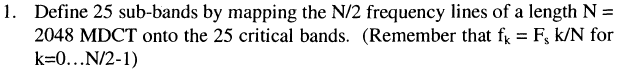

In [57]:
#bark scale
def bark(f):
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

def get_subband_index(f):
    return int(bark(f))

def bin_to_subband_index(k, fs=48000, N=2048):
    return 1 + int(bark(k * fs / N))

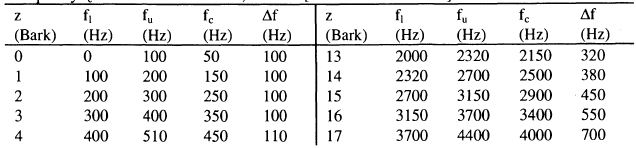

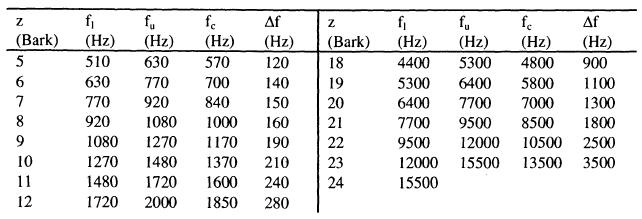

In [60]:
print(bin_to_subband_index(0, fs, N))
print(bin_to_subband_index(1023, fs, N))

1
25


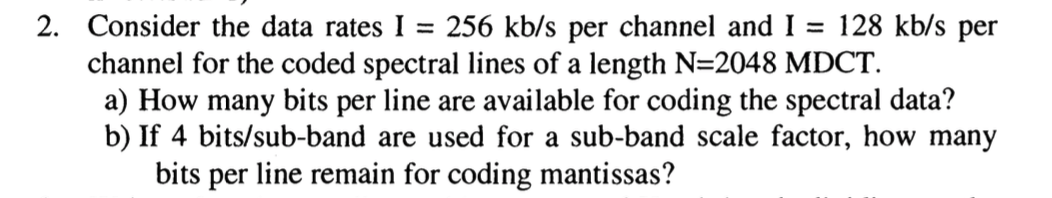

In [5]:
def R_k(data_rate, fs):
    return data_rate / fs

def block_bits_per_channel(R_k, N) :
    return R_k * N / 2

In [63]:
R_k_1 = R_k(256000, fs)
print(R_k_1)
R_k_2 = R_k(128000, fs)
print(R_k_2)

5.333333333333333
2.6666666666666665


In [67]:
lines = N//2
mantissa_bits_1 = int(block_bits_per_channel(R_k_1, N) - 100)

bits_per_line_1 = mantissa_bits_1 / lines
print(bits_per_line_1)

5.2353515625


In [68]:
lines = N//2
mantissa_bits_2 = int(block_bits_per_channel(R_k_2, N) - 100)

bits_per_line_2 = mantissa_bits_2 / lines
print(bits_per_line_2)

2.568359375


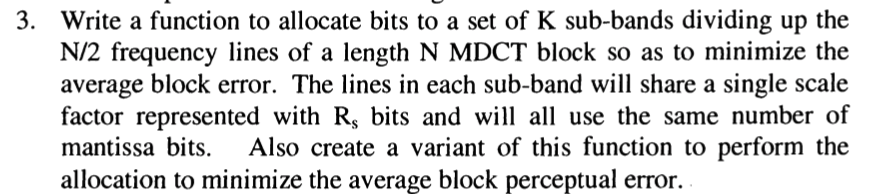

In [6]:
K = 25
k_map = {k:0 for k in range(1, K+1)}

for bin in range(N//2): 
    k = bin_to_subband_index(bin, fs, N)
    k_map[k] = k_map[k] + 1
k_map

{1: 5,
 2: 4,
 3: 5,
 4: 4,
 5: 5,
 6: 5,
 7: 6,
 8: 6,
 9: 7,
 10: 7,
 11: 9,
 12: 10,
 13: 11,
 14: 15,
 15: 17,
 16: 22,
 17: 26,
 18: 31,
 19: 36,
 20: 43,
 21: 52,
 22: 66,
 23: 96,
 24: 171,
 25: 365}

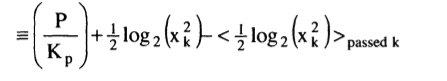

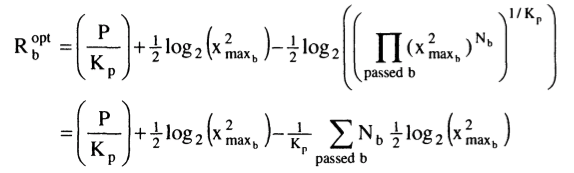

In [7]:
def bit_allocation_greedy(K_p, P, N_b, xmax_b):
    
    avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2))/K_p
    buffer = np.array((P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg)
    
    positives = np.ones_like(buffer)
    while np.any(buffer < 0):
        positives[np.nonzero(buffer < 0)[0]] = 0
        K_p = np.count_nonzero(positives)
        
        avg = np.sum(0.5 * np.array(N_b) * np.log2(xmax_b ** 2) * positives) / K_p
        buffer = np.array((P/K_p) + 0.5 * np.array(N_b) * np.log2(xmax_b ** 2) - avg) * positives
        
    return buffer

In [8]:
total_bits = int(block_bits_per_channel(R_k(256000, fs), N) - 100)
samples = np.random.rand(K)
allocation = bit_allocation_greedy(K, total_bits, np.array(list(k_map.values())), samples) 
allocation

array([254.47281089, 255.62065406, 255.66085191, 252.73531288,
       256.52772998, 249.6191458 , 250.33410155, 247.72408954,
       254.64559405, 249.63319303, 254.53760623, 234.97733723,
       201.55591682, 234.15589177, 227.98332888, 227.35785811,
       243.23424406, 215.72539843, 153.05920954, 250.83301773,
       231.50991494, 214.13026075,  71.28581855,  -0.        ,
        73.68071328])

In [9]:
np.sum(allocation)

5361.0

In [10]:
class MDCT():
    def __init__(self, N: int, window: np.ndarray):
        K = N//2
        self.n_0 = ((N/2) + 1)/2

        A = np.zeros((K,N))
        for k in range(K):
            for n in range(N):
                A[k,n] = np.cos((2*np.pi/N)*(n + self.n_0)*(k+1/2))

        self.N = N
        self.window = window
        self.A_1 = A[:,:N//2]
        self.A_2 = A[:,N//2:]
        self.B_1 = (4/N)*self.A_1.T
        self.B_2 = (4/N)*self.A_2.T

        self.A = A
        self.B = (4/N)*A.T

        if window.shape[0] != N:
            raise ValueError(f"Window is not the same size as N! Window size: {window.shape[0]}")

    def _preprocess(self, x: np.ndarray):
        L = len(x)
        self.frames = L//(self.N//2) + 1
        r = L%(self.N//2)
        return np.pad(x, (self.N // 2, self.N // 2 - r))


    def mdct(self, x: np.ndarray):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = self.A @ (frame * self.window)

        return X

    def imdct(self, X: np.ndarray):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += (self.B @ X[:,frame_idx]) * self.window
            
        return x_padded[self.N//2:-self.N//2]
    
    def mdct_pre_twiddle(self):
        return np.exp(-2j * np.pi * np.arange(self.N) / (2*self.N))

    def mdct_post_twiddle(self):
        return np.exp(-2j * np.pi * self.n_0 * (np.arange(self.N//2) + 0.5) / self.N)


    def mdct_via_fft(self, x):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = np.real(
                self.mdct_post_twiddle() * np.fft.fft(frame * self.window * self.mdct_pre_twiddle())[:self.N//2]
            )
        
        return X 
    
    def imdct_pre_twiddle(self):
        return np.exp(2j * np.pi * self.n_0 * np.arange(self.N) / self.N)

    def imdct_post_twiddle(self):
        return np.exp(2j * np.pi * (np.arange(self.N) + self.n_0) / (2*self.N))
    
    def imdct_via_ifft(self, X):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += \
            np.real(np.fft.ifft(np.concatenate((X[:,frame_idx], -X[::-1,frame_idx])) * self.imdct_pre_twiddle()) * \
            self.imdct_post_twiddle()) * 2 * self.window
            
        return x_padded[self.N//2:-self.N//2]

In [11]:
def sine_window(N):
    M = N//2
    w = np.zeros((N,1))

    for n in range(N-M):
        w[n] = np.sin((np.pi/2)*(n+1/2)/(N-M))
        
    for n in range(N-M,M):
        w[n] = 1

    for n in range(M,N):
        w[n] = np.sin((np.pi/2)*(N - n - 1/2)/(N-M))

    return w.reshape(-1)

In [12]:
n = np.arange(N)
T = N/fs
t = np.linspace(0, T, N)

A0 = 0.6
A1 = 0.55
A2 = 0.55
A3 = 0.15
A4 = 0.1
A5 = 0.05


x = A0 * np.cos(2 * np.pi * n * 440/fs) \
  + A1 * np.cos(2 * np.pi * n * 554/fs) \
  + A2 * np.cos(2 * np.pi * n * 660/fs) \
  + A3 * np.cos(2 * np.pi * n * 880/fs) \
  + A4 * np.cos(2 * np.pi * n * 4400/fs) \
  + A5 * np.cos(2 * np.pi * n * 8800/fs)

my_mdct = MDCT(N, sine_window(N))

X_mdct = my_mdct.mdct(x)

bins = np.arange(X_mdct.shape[0])
omega_mdct = (bins * fs / N)

In [13]:
df = pd.DataFrame({'bin': range(1024), 'mdct': X_mdct[:, 1]})
df["subband"] = df["bin"].apply(bin_to_subband_index)
df.drop(columns = ["bin"], inplace = True)
x_max_b = df.groupby(by=["subband"]).max()["mdct"].to_numpy()
list(x_max_b)

[0.4966768818833803,
 0.7429672999517216,
 1.4116945568944876,
 4.456689101729536,
 76.52147206841722,
 132.06992533949497,
 27.645872037711957,
 28.55540551915366,
 1.366376183452271,
 0.2702751073171819,
 0.1867925665061234,
 0.09195786851856802,
 0.06572046508932601,
 0.04418524341496753,
 0.02961584693490034,
 0.02221436460617579,
 0.027652634286610876,
 20.666898274915138,
 0.10499554135524351,
 0.009644693284610107,
 0.005523728201437539,
 32.38106678658765,
 0.026285635391936697,
 0.0015148725712350597,
 0.0005077970079349209]

In [14]:
alloc = bit_allocation_greedy(K, total_bits, np.array(list(k_map.values())), x_max_b)
alloc, np.sum(alloc)

(array([265.03136607, 268.36495104, 272.56660842, 278.70335785,
        301.36843217, 305.30525939, 298.81342161, 299.09362037,
        273.2319517 , 256.8669724 , 248.2950491 , 235.65063693,
        226.87682006, 202.57509519, 183.76219218, 149.24747567,
        135.49204763, 405.52621787, 153.02186749,  -0.        ,
         -0.        , 601.20665686,  -0.        ,  -0.        ,
         -0.        ]),
 5361.0)

In [15]:
def bit_allocation_perceptual_greedy(K_p, P, N_b, SMR_b):
    
    avg = np.sum(np.array(N_b) * SMR_b)/K_p
    buffer = np.array((P/K_p) + (np.log(10) / (20 * np.log(2))) * (SMR_b - avg))
    
#     positives = np.ones_like(buffer)
#     while np.any(buffer < 0):
#         positives[np.nonzero(buffer < 0)[0]] = 0
#         K_p = np.count_nonzero(positives)
        
#         avg = np.sum(np.array(N_b) * SMR_b * positives)/K_p
#         buffer = np.array((P/K_p) + (np.log(10) / (20 * np.log(2))) * (SMR_b - avg)) * positives
        
    return buffer

In [46]:
def spl(X, N_fft, N_w):
    bw_factor = N_fft / (2 * N_w)
    norm = (N_w * N_fft / 8)
    
    peaks, _ = signal.find_peaks(X, height=0.1)
    SPL = np.zeros(peaks.shape)
    for i, p in enumerate(peaks):
        # adding half band samples to each side of the peak
        peak_energy = np.sum(np.abs(X[p - int(np.ceil(3 * bw_factor)):p + int(np.ceil(3 * bw_factor))]) ** 2) / norm
        SPL[i] = 96 + 10 * np.log10(peak_energy)
    
    return SPL, peaks

def spl_by_sample(X, N_fft, N_w):
    norm = (N_w * N_fft / 8)
    return 96 + 10 * np.log10(np.abs(X) ** 2 / norm)

In [18]:
def bark(f):
    return 13 * np.arctan(.76 * (f / 1000)) + 3.5 * np.arctan((f / 7500) ** 2)

def delta_tone_masking_noise(z, delta):
    return delta + z

def masking_model(bark, SPL, peaks, delta=15):
    sf_peaks = np.zeros((len(bark), len(bark)))
    
    teta = np.zeros_like(bark)
    for i in range(peaks.shape[0]):
        dz = bark - bark[i]
        teta[dz > 0] = 1
        
        # spreading function
        sf = ((-27 + 0.37 * np.max((SPL[i] - 40), 0) * teta) * np.abs(dz))
        
        # masking model
        sf_peaks[i] = np.maximum(SPL[i] + sf - delta_tone_masking_noise(bark[i], delta), 0)
             
    return sf_peaks

In [47]:
SPL, peaks = spl(X_mdct[:, 1], N, N)
SPL_sample = spl_by_sample(X_mdct[:, 1], N, N)
bark_freqs = bark(omega_mdct)
sf_peaks = masking_model(bark_freqs, SPL, peaks)

print(f'SPL: {SPL.shape}')
print(f'peaks: {peaks.shape}')
print(f'SPL_sample: {SPL_sample.shape}')
print(f'bark_freqs: {bark_freqs.shape}')
print(f'sf_peaks: {sf_peaks.shape}')

SPL: (27,)
peaks: (27,)
SPL_sample: (1024,)
bark_freqs: (1024,)
sf_peaks: (1024, 1024)


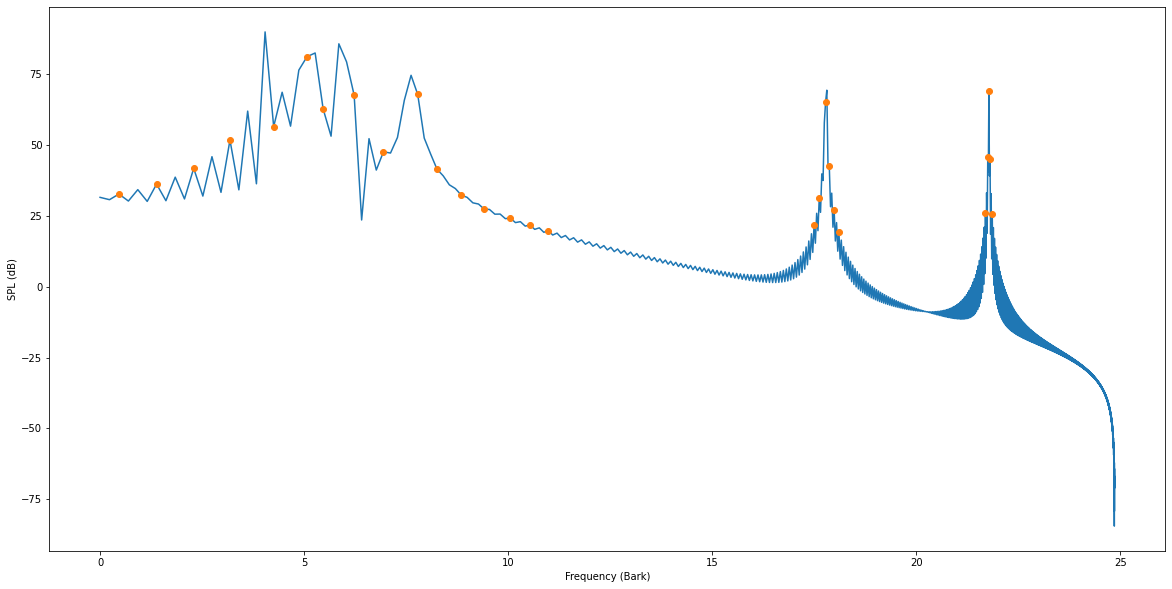

In [48]:
plt.figure(figsize=(20,10))
plt.plot(bark_freqs, SPL_sample)
plt.plot(bark_freqs[peaks], SPL_sample[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

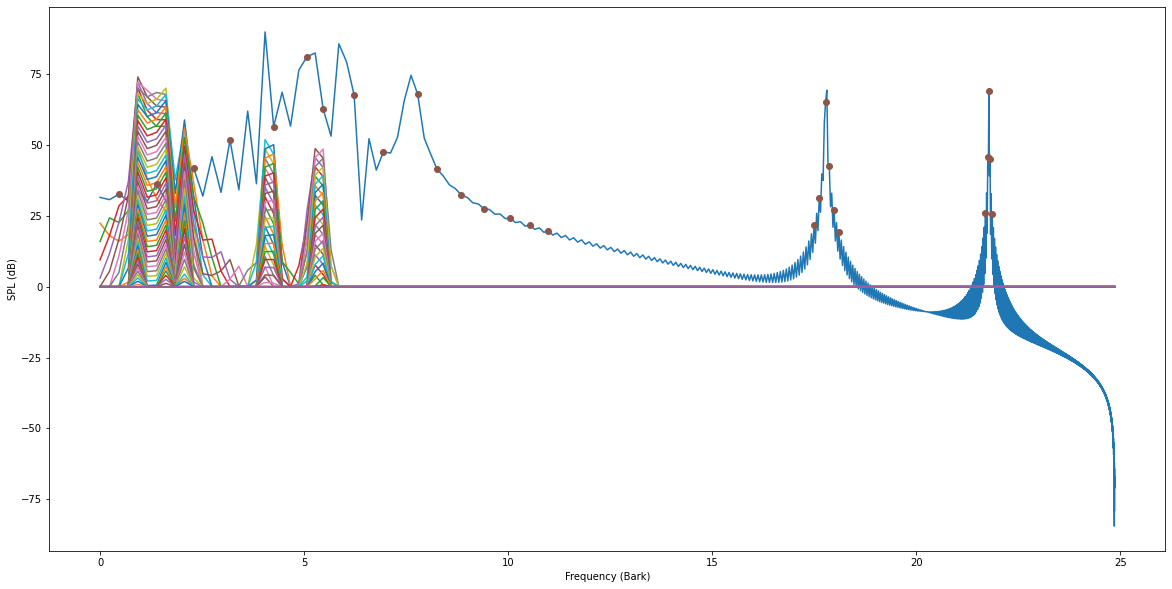

In [49]:
plt.figure(figsize=(20,10))
plt.plot(bark_freqs, SPL_sample)
plt.plot(bark_freqs, sf_peaks)
plt.plot(bark_freqs[peaks], SPL_sample[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

In [50]:
w = sine_window(N)
x_w = x[:N] * w
X_fft = np.fft.fft(x_w, n=N)[:N//2]
omega_fft = np.fft.fftfreq(N)[:N//2]

In [51]:
SPL, peaks = spl(X_fft, N, N)
SPL_sample = spl_by_sample(X_fft, N, N)
bark_freqs = bark(omega_fft)
sf_peaks = masking_model(bark_freqs, SPL, peaks)

print(f'SPL: {SPL.shape}')
print(f'peaks: {peaks.shape}')
print(f'SPL_sample: {SPL_sample.shape}')
print(f'bark_freqs: {bark_freqs.shape}')
print(f'sf_peaks: {sf_peaks.shape}')

SPL: (6,)
peaks: (6,)
SPL_sample: (1024,)
bark_freqs: (1024,)
sf_peaks: (1024, 1024)


/home/gbfelgas/miniconda3/envs/cpe793/lib/python3.9/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


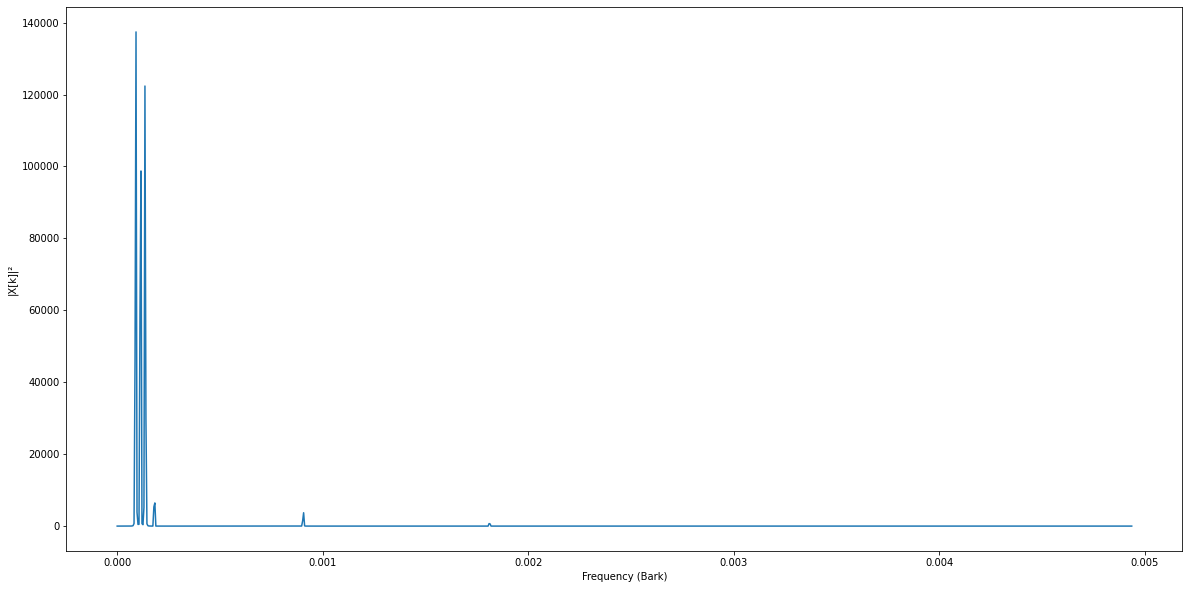

In [52]:
plt.figure(figsize=(20,10))
plt.plot(bark_freqs, np.abs(X_fft) ** 2)
plt.ylabel('|X[k]|²')
plt.xlabel('Frequency (Bark)')
plt.show()

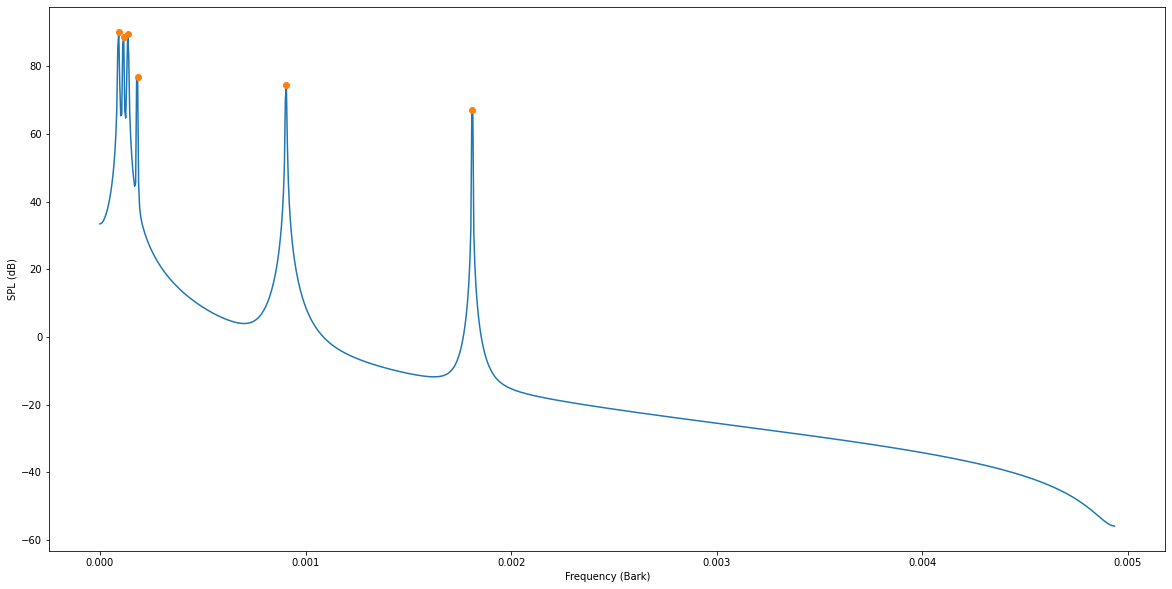

In [53]:
plt.figure(figsize=(20,10))
plt.plot(bark_freqs, SPL_sample)
plt.plot(bark_freqs[peaks], SPL_sample[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

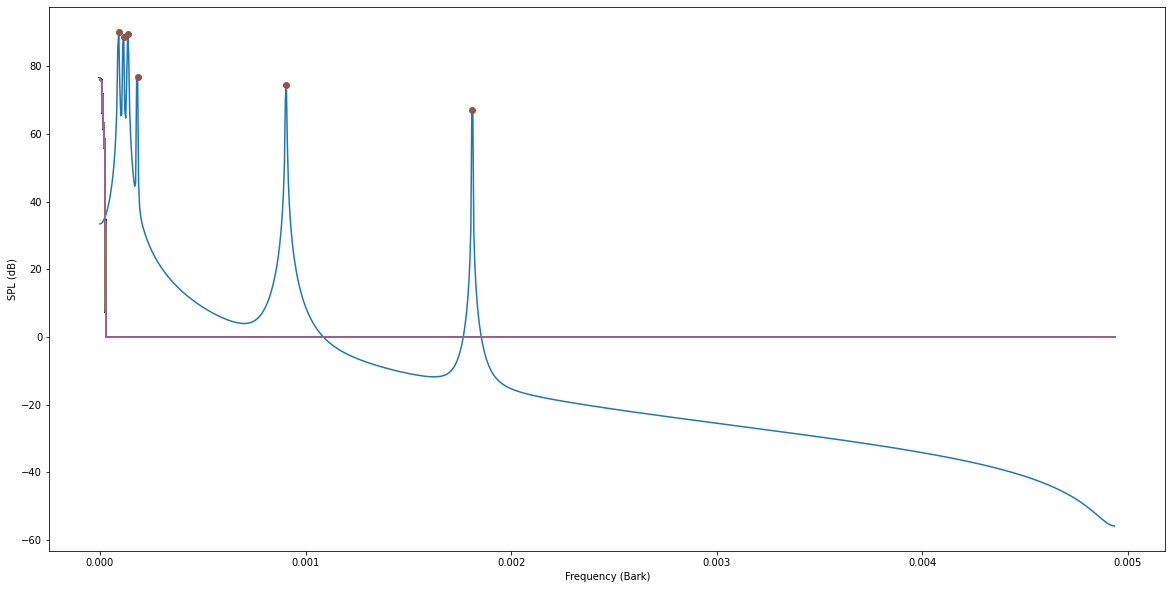

In [54]:
plt.figure(figsize=(20,10))
plt.plot(bark_freqs, SPL_sample)
plt.plot(bark_freqs, sf_peaks)
plt.plot(bark_freqs[peaks], SPL_sample[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

In [21]:
sf_peaks.shape

(1024, 1024)

In [ ]:
from scipy.interpolate import interp1d

#number of steps N in z
N_z = 1000

#bark scale
def bark(f):
    return 13 * np.arctan(.76 * (f / 1000)) + 3.5 * np.arctan((f / 7500)**2)


#spreading of masking
def spreading_f(dz,L):
    return (-27+.37*np.max(L-40,0)*np.heaviside(dz,1))*np.abs(dz)

def delta_tone_masking_noise(z):
    return 14.5+z#dB -> in text it's 14.5 but in the end of the chapter, to generate the chart, it was used delta=15 dB

#not used
def sum1(arr, alpha):
    return np.power(np.sum(np.power(arr,alpha)),1/alpha)

#max
def sum2(arr):
    return np.max(arr)

def calc_SMR(spl, z, mask, N=N_z):
    z_values = np.linspace(0,25,N)
    mask_arg = np.argmin(np.abs(z_values-z))
    return spl-mask[mask_arg]

def masking_model(z,L,N):
    mask = L+spreading_f(np.linspace(-z,25-z,N),L)-delta_tone_masking_noise(z)
    return mask

masks = []
for i in range(A.shape[-1]):
    masks.append(masking_model(bark(freq[i]),F[i],N_z)) #each frequency mask
#
# print(list(masks)[1])
masks = np.matrix(masks)#= np.concatenate(list(masks),0)
mask = np.zeros(masks.shape[-1])
for i in range(masks.shape[-1]):
    mask[i] = sum2(masks[:,i]) #combination of all masks

spl_fft_x = 10*np.log10((np.abs(X_w)**2/(N*N_fft/8))/E0)

#print(bark(f).shape[-1])
#print(t.shape[-1])

z_values = np.linspace(0,25,N_z)
mask_interp_z = interp1d(z_values,mask) #interpolation of mask for z values
threshold_interp_z = interp1d(bark(f),t) #interpolation of threshold for z values
#spl_fft_x_interp_z = interp1d(bark(omega*F_s), spl_fft_x, kind='quadratic')
omega_in_bark = bark(omega*F_s) #omegas of FFT in bark values

bits = np.zeros(N)
final_mask = np.zeros(N)
#print(z_values[:2])
print(threshold_interp_z(24.5))

for i in range(N):
    #combine threshold in silence with mask
    if omega_in_bark[i]>=.2 and omega_in_bark[i]<=24.575: final_mask[i] = sum2((threshold_interp_z(omega_in_bark[i]), mask_interp_z(omega_in_bark[i])))
    #bits of each frequency component
    bits[i] = max(np.ceil((spl_fft_x[i]-final_mask[i])/6),0) 

for i in range(freq.shape[-1]):
    print(f'SMR(f={freq[i]}): {calc_SMR(F[i],bark(freq[i]),mask)}')

fig, axs = plt.subplots(1, figsize=(16,4))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axs2 = axs.twinx()
axs2.set_ylabel('bits')
color='tab:red'
#axs.plot(omega_in_bark,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.plot(omega*F_s,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.set_xlim(20,10000)
#axs.set_xlim(0.2,24)
axs.scatter(freq,F, c='r', marker='.', label=r'$SPL(f_n)$ [From FFT]')
#axs.plot(omega_in_bark,final_mask, label='Mask+Threshold')
#axs2.plot(omega_in_bark, bits, label='bits', color=color)
axs.plot(omega*F_s,final_mask, label='Mask+Threshold')
axs2.plot(omega*F_s, bits, label='bits', color=color)
axs.set_ylim(-5,130)
axs.grid()
#axs.set_xlabel('Barks')
axs.set_xlabel('Hz')
axs.set_ylabel('SPL')
axs.legend()
axs2.tick_params(axis='y', labelcolor=color)

In [ ]:
F_s = 48000
n = np.arange(F_s+1)
f0 = 1000
x = np.sin(2*np.pi*f0*n/F_s)
N = 2048
N_fft = N*8

w = sin_w(N)
bw = 3*F_s/N

x_w = x[0:N]*w
print(x_w.shape[-1])

X_w = np.fft.fftshift(np.fft.fft(x_w,n=int(N_fft)))
omega = np.fft.fftshift(np.fft.fftfreq(X_w.shape[-1]))
print(f'Normalized area: {np.sum(np.square(np.abs(X_w[:int(N_fft/2)]))/(N**2*8/8))}')
max_norm_freq_comp = (np.max(np.square(np.abs(X_w))/(N**2/8)))
amp_3dB_arg = np.argmin(np.abs(np.square(np.abs(X_w))/(N**2/8)-max_norm_freq_comp/2))

###############################
# 6.12 Item 2
###############################
A = np.array([.6, .55, .55, .15, .1, .05])
freq = np.array([440, 554, 660, 880, 4400, 8800])
w = sin_w(N)
x = np.zeros(n.shape[-1])
for i in range(A.shape[-1]): x += A[i]*np.sin(2*np.pi*freq[i]*n/F_s)
x_w = x[0:N]*w

N_fft = N
bw = 3*F_s/N

def get_idx(f_array, f):
    return np.argmin(np.abs(f_array-f))

def spl(x, w, f_arr, N_fft, F_s, E0=10**(-9.6)):
    #print(f,N_fft,F_s)
    N = w.shape[-1]
    bw_factor = N_fft/(2*N)
    x_w = x[:N]*w
    X_w = np.fft.fftshift(np.fft.fft(x_w,n=N_fft))
    omega = np.fft.fftshift(np.fft.fftfreq(N_fft))
    idx = np.zeros(f_arr.shape[-1], dtype=int)
    for i in range(f_arr.shape[-1]):
        idx[i] = get_idx(omega*F_s,f_arr[i])
    F = np.array([10*np.log10(np.sum(np.abs(X_w[idx[i]-int(np.ceil(3*bw_factor)):idx[i]+int(np.ceil(3*bw_factor))])**2)/(N*N_fft/8)/E0) for i in range(f_arr.shape[-1])])
    return F


#reference amplitude
E0 = 10**(-96/10)

X_w = np.fft.fftshift(np.fft.fft(x_w,n=N_fft))
omega = np.fft.fftshift(np.fft.fftfreq(X_w.shape[-1]))

F = spl(x,w,freq,N_fft,F_s)

#Threshold in quiet (dB)
f = np.linspace(20, 20000, 1000)
t = 3.64*(f/1000)**(-.8)-6.5*np.exp(-.6*(f/1000-3.3)**2)+10**(-3)*(f/1000)**4

In [ ]:
from scipy.interpolate import interp1d

#number of steps N in z
N_z = 1000

#bark scale
def bark(f):
    return 13*np.arctan(.76*f/1000)+3.5*np.arctan((f/7500)**2)

#spreading of masking
def spreading_f(dz,L):
    return (-27+.37*np.max(L-40,0)*np.heaviside(dz,1))*np.abs(dz)

def delta_tone_masking_noise(z):
    return 14.5+z#dB -> in text it's 14.5 but in the end of the chapter, to generate the chart, it was used delta=15 dB

#not used
def sum1(arr, alpha):
    return np.power(np.sum(np.power(arr,alpha)),1/alpha)

#max
def sum2(arr):
    return np.max(arr)

def calc_SMR(spl, z, mask, N=N_z):
    z_values = np.linspace(0,25,N)
    mask_arg = np.argmin(np.abs(z_values-z))
    return spl-mask[mask_arg]

def masking_model(z,L,N):
    mask = L+spreading_f(np.linspace(-z,25-z,N),L)-delta_tone_masking_noise(z)
    return mask

masks = []
for i in range(A.shape[-1]):
    masks.append(masking_model(bark(freq[i]),F[i],N_z)) #each frequency mask
#
# print(list(masks)[1])
masks = np.matrix(masks)#= np.concatenate(list(masks),0)
mask = np.zeros(masks.shape[-1])
for i in range(masks.shape[-1]):
    mask[i] = sum2(masks[:,i]) #combination of all masks

spl_fft_x = 10*np.log10((np.abs(X_w)**2/(N*N_fft/8))/E0)

#print(bark(f).shape[-1])
#print(t.shape[-1])

z_values = np.linspace(0,25,N_z)
mask_interp_z = interp1d(z_values,mask) #interpolation of mask for z values
threshold_interp_z = interp1d(bark(f),t) #interpolation of threshold for z values
#spl_fft_x_interp_z = interp1d(bark(omega*F_s), spl_fft_x, kind='quadratic')
omega_in_bark = bark(omega*F_s) #omegas of FFT in bark values

bits = np.zeros(N)
final_mask = np.zeros(N)
#print(z_values[:2])
print(threshold_interp_z(24.5))

for i in range(N):
    #combine threshold in silence with mask
    if omega_in_bark[i]>=.2 and omega_in_bark[i]<=24.575: final_mask[i] = sum2((threshold_interp_z(omega_in_bark[i]), mask_interp_z(omega_in_bark[i])))
    #bits of each frequency component
    bits[i] = max(np.ceil((spl_fft_x[i]-final_mask[i])/6),0) 

for i in range(freq.shape[-1]):
    print(f'SMR(f={freq[i]}): {calc_SMR(F[i],bark(freq[i]),mask)}')

fig, axs = plt.subplots(1, figsize=(16,4))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axs2 = axs.twinx()
axs2.set_ylabel('bits')
color='tab:red'
#axs.plot(omega_in_bark,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.plot(omega*F_s,spl_fft_x, label=r'$SPL(FFT(x))$')
axs.set_xlim(20,10000)
#axs.set_xlim(0.2,24)
axs.scatter(freq,F, c='r', marker='.', label=r'$SPL(f_n)$ [From FFT]')
#axs.plot(omega_in_bark,final_mask, label='Mask+Threshold')
#axs2.plot(omega_in_bark, bits, label='bits', color=color)
axs.plot(omega*F_s,final_mask, label='Mask+Threshold')
axs2.plot(omega*F_s, bits, label='bits', color=color)
axs.set_ylim(-5,130)
axs.grid()
#axs.set_xlabel('Barks')
axs.set_xlabel('Hz')
axs.set_ylabel('SPL')
axs.legend()
axs2.tick_params(axis='y', labelcolor=color)